<a href="https://colab.research.google.com/github/Rafi076/RTFER_Framework/blob/main/RTFER_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rafi076/RTFER_Framework.git

Cloning into 'RTFER_Framework'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 4), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 41.32 KiB | 3.18 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# STEP 2: Correct zip path (case-sensitive, and spelling checked)
zip_path = '/content/drive/MyDrive/RTFER_Framwork/FER-2013.zip'
extract_to = '/content'  # Since zip already has a folder inside, extract to /content

# STEP 3: Unzip
import zipfile, os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [4]:
# Show contents of the extracted folder
!ls "/content/FER-2013"

test  train


**Step 3: Import Libraries**

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix


**Step 4: Define Transforms for Data Augmentation**

In [6]:
# Step 4 - Updated Transforms
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert grayscale to 3 channels
    transforms.Resize((224, 224)),                # match ResNet input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet mean
                         std=[0.229, 0.224, 0.225])    # ImageNet std
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


**Step 5: Load the Dataset**

We load images using ImageFolder.

In [7]:
train_dir = "/content/FER-2013/train"
test_dir = "/content/FER-2013/test"

train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
from torch.utils.data import Subset, DataLoader
import numpy as np

# Split train_dataset into train and validation
val_percent = 0.1  # 10% for validation
num_val = int(len(train_data) * val_percent)
indices = np.random.permutation(len(train_data))

val_indices = indices[:num_val]
train_indices = indices[num_val:]

train_subset = Subset(train_data, train_indices)
val_subset = Subset(train_data, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


**Step 6: Visualize Sample Images**

Before training, let’s confirm that the images and labels are loading correctly:

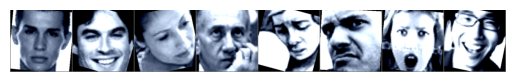

sad happy sad happy sad angry surprise happy


In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Helper function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Show labels
print(' '.join(f'{class_names[labels[j]]}' for j in range(8)))


**Step 7: Build the CNN Model**

We’ll start with a simple custom CNN model. Later, we can improve it or use pretrained models like ResNet.

In [10]:
from torchvision import models
import torch.nn as nn

class ResNetFER(nn.Module):
    def __init__(self):
        super(ResNetFER, self).__init__()
        self.model = models.resnet18(pretrained=True)  # keep pretrained weights
        self.model.fc = nn.Linear(self.model.fc.in_features, 7)  # 7 emotions

    def forward(self, x):
        return self.model(x)


**Step 8: Define Loss, Optimizer, and Move Model to GPU**

In [11]:
# ✅ Step 8: Model setup, optimizer, loss, scheduler, early stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetFER().to(device)

# 🔧 Enable cuDNN auto-tuner for faster training on GPU
torch.backends.cudnn.benchmark = True

# 🔒 Freeze all pretrained layers
for param in model.model.parameters():
    param.requires_grad = False

# 🔓 Unfreeze the last layer/block for fine-tuning
for param in model.model.layer4.parameters():
    param.requires_grad = True
for param in model.model.fc.parameters():
    param.requires_grad = True

# ✅ Optimizer & Loss
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()

# ✅ Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

# ✅ Early stopping config
best_val_acc = 0.0
patience = 4
patience_counter = 0
best_model_state = None


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


**Step 9: Train the Model**

Let’s train for 10 epochs and monitor loss and accuracy.

In [ ]:
from tqdm import tqdm

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # === VALIDATION ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # === EARLY STOPPING ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🔥 Early stopping triggered at epoch {epoch+1}")
            break

# Restore the best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model restored with val accuracy: {best_val_acc:.2f}%")


Epoch 1/20: 100%|██████████| 404/404 [1:10:50<00:00, 10.52s/it]


Epoch 1, Train Loss: 520.6873, Train Acc: 51.17%, Val Loss: 52.6930, Val Acc: 56.97%


Epoch 2/20: 100%|██████████| 404/404 [1:09:43<00:00, 10.36s/it]


Epoch 2, Train Loss: 430.2095, Train Acc: 60.10%, Val Loss: 49.5496, Val Acc: 58.64%


Epoch 3/20: 100%|██████████| 404/404 [1:09:30<00:00, 10.32s/it]


Epoch 3, Train Loss: 394.5253, Train Acc: 63.51%, Val Loss: 46.9003, Val Acc: 62.20%


Epoch 4/20: 100%|██████████| 404/404 [1:09:45<00:00, 10.36s/it]


Epoch 4, Train Loss: 366.3061, Train Acc: 66.24%, Val Loss: 46.7785, Val Acc: 61.36%


Epoch 5/20: 100%|██████████| 404/404 [1:09:57<00:00, 10.39s/it]


Epoch 5, Train Loss: 341.0449, Train Acc: 68.52%, Val Loss: 46.9016, Val Acc: 61.11%


Epoch 6/20: 100%|██████████| 404/404 [1:10:06<00:00, 10.41s/it]


Epoch 6, Train Loss: 318.3831, Train Acc: 70.87%, Val Loss: 45.8486, Val Acc: 62.82%


Epoch 7/20: 100%|██████████| 404/404 [1:10:50<00:00, 10.52s/it]


Epoch 7, Train Loss: 296.7180, Train Acc: 73.06%, Val Loss: 46.1901, Val Acc: 64.29%


Epoch 8/20: 100%|██████████| 404/404 [1:09:19<00:00, 10.30s/it]


Epoch 8, Train Loss: 272.3431, Train Acc: 75.60%, Val Loss: 49.0675, Val Acc: 62.61%


Epoch 9/20: 100%|██████████| 404/404 [1:08:45<00:00, 10.21s/it]


Epoch 9, Train Loss: 251.3353, Train Acc: 77.27%, Val Loss: 49.3847, Val Acc: 63.38%


Epoch 10/20:  62%|██████▏   | 251/404 [42:49<26:21, 10.34s/it]